In [1]:
import numpy as np
from hyperopt import hp, fmin, tpe, space_eval
from scikits.odes.ode import ode
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [16]:
def old_p_aminostyrene(t, y, ydot, params):
    chorismate, pa1, pa2, pa3, paf, paca_int, paca_ext, promoter1, pap_mrna, pap_ared_folded, pap_ared_cleaved, papA_uf, papA, papB_uf, papB, papC_uf, papC, deaminase, promoter2, laao_mrna, laao_ared_folded, laao_ared_cleaved, laao_uf, laao, promoter3, eff_mrna, eff_ared_folded, eff_ared_cleaved, eff_uf, eff = y

    A, W = params

    dilution_rate = 5.79E-4
    dna_duplication_rate = 5.78E-4
    ki = 5E-5 #range [1E-5, 1E-4]
    tl = 50 #range [1E1, 1E2]
    tp = 50 #range [1E1, 1E2]
    ta = 5E-4 #range [1E-4, 1E-3]
    toxicity_factor = ki/(ki + (ta*paca_int + tp*ef + tl*laao))

    pap_mrnalength = 3400
    eff_mrnalength = 2900
    laao_mrnalength = 1600
    tr_mrnalength = 1100
    srna_length = 200
    cell_volume = 2.5E-15
    ribosome_elongation = 20
    rnap_elongation = 25
    ligand_activation_ratio = 0.17
    txn_init = 2E-1
    tsn_init = 2E-1

    mrna_degradation_rate = 3E-3 #range [3E-4, 3E-2]
    protein_degradation_rate = 2E-4 #range [2E-5, 2E-3]
    cleaved_mrna_degradation_rate = 0.
    protein_folding_rate = 2E0 #range [2E-1, 2E1]
    pap_translation_rate = ((pap_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation))) 
    pap_ared_folded_translation_rate = ((pap_ared_folded)/(tsn_init + (pap_mrnalength/ribosome_elongation))) 
    pap_ared_cleaved_translation_rate = ((pap_ared_cleaved)/(tsn_init + (pap_mrnalength/ribosome_elongation))) 
    ared_folding_rate = 1.5E-2 #range [1.5E-3, 1.5E-1]
    kobs_m = 1E-2 #range [1E-4, 1E-1]
    EC50 = 1E-6 #range [1E-7, 1E-5]
    ligand_activation_ratio_cleavage = 1E1 #range [1E0, 1E2]
    kobs_p = kobs_m * ligand_activation_ratio_cleavage

    pap_ared_cleavage_rate = ((pap_ared_folded*(kobs_p - kobs_m))/(1+(EC50/ligand))) + kobs_m #Ligand should be determined by architecture?? FIX THIS
    laao_ared_cleavage_rate = pap_ared_cleavage_rate#FIX THIS
    eff_ared_cleavage_rate = pap_ared_cleavage_rate #FIX THIS

    laao_translation_rate = ((laao_mrna)/(tsn_init + (laao_mrnalength/ribosome_elongation))) 
    laao_ared_folded_translation_rate = ((laao_ared_folded)/(tsn_init + (laao_mrnalength/ribosome_elongation))) 
    laao_ared_cleaved_translation_rate = ((laao_ared_cleaved)/(tsn_init + (laao_mrnalength/ribosome_elongation))) 
    
    eff_translation_rate = ((eff_mrna)/(tsn_init + (eff_mrnalength/ribosome_elongation))) 
    eff_ared_folded_translation_rate = ((eff_ared_folded)/(tsn_init + (eff_mrnalength/ribosome_elongation))) 
    eff_ared_cleaved_translation_rate = ((eff_ared_cleaved)/(tsn_init + (eff_mrnalength/ribosome_elongation))) 
    
    deaminase_production_rate =  1E1 #range [1E0, 1E2]
    chorismate_production_rate = 1100. #range [2E2, 2E3]
    enzyme_kcat = 5E0 #range [5E-1, 5E1]
    enzyme_km = 1E-6 #range [1E-7, 1E-5]
    avogadro = 6.0221408e+23
    efflux_rate = 275. #range [5E1, 5E2]

    #Genetic equations - must be affected by control topology - FIX THIS
    pap_mrna_transcription_rate = ((promoter1)/(txn_init + (pap_mrnalength/rnap_elongation))) #Uncertain if this is correct
    laao_mrna_transcription_rate = pap_mrna_transcription_rate
    eff_mrna_transcription_rate = pap_mrna_transcription_rate

    #Write out all 92 reactions in the cell
    pa1_dil = pa1*dilution_rate
    pa2_dil = pa2*dilution_rate
    pa3_dil = pa3*dilution_rate
    paf_dil = paf*dilution_rate
    paca_int_dil = paca_int*dilution_rate
    cho_dil = chorismate*dilution_rate
    deam_dil = deaminase*dilution_rate
    paf_loss = paf*1.40E-5 #range [1.4E-6, 1.4E-4]
    prom1_div = promoter1*dna_duplication_rate
    prom1_dil = promoter1*dilution_rate
    prom2_div = promoter2*dna_duplication_rate
    prom2_dil = promoter2*dilution_rate
    prom3_div = promoter3*dna_duplication_rate
    prom3_dil = promoter3*dilution_rate
    pap_mrna_txn =  promoter1 * pap_mrna_transcription_rate * toxicity_factor #FIX THIS
    pap_mrna_dil = pap_mrna * dilution_rate
    pap_mrna_deg = pap_mrna * mrna_degradation_rate * toxicity_factor
    papA_tsn = pap_translation_rate * toxicity_factor
    papA_folding = papA_uf * protein_folding_rate * toxicity_factor
    papA_uf_dil = papA_uf* dilution_rate
    papA_dil = papA*dilution_rate
    papA_uf_deg = papA_uf * protein_degradation_rate * toxicity_factor
    papA_deg = papA * protein_degradation_rate * toxicity_factor
    papB_tsn = pap_translation_rate * toxicity_factor
    papB_folding = papB_uf * protein_folding_rate * toxicity_factor
    papB_uf_dil = papB_uf * dilution_rate
    papB_dil = papB * dilution_rate
    papB_uf_deg = papB_uf * protein_degradation_rate * toxicity_factor
    papB_deg = papB * protein_degradation_rate * toxicity_factor
    papC_tsn = pap_translation_rate * toxicity_factor
    papC_folding = papC_uf * protein_folding_rate * toxicity_factor
    papC_uf_dil = papC_uf * dilution_rate
    papC_dil = papC * dilution_rate
    papC_uf_deg = papC_uf * protein_degradation_rate * toxicity_factor
    papC_deg = papC * protein_degradation_rate * toxicity_factor
    papA_ared_folded_tsn = pap_ared_folded * pap_ared_folded_translation_rate * toxicity_factor
    papA_ared_cleaved_tsn = pap_ared_cleaved * pap_ared_cleaved_translation_rate * toxicity_factor
    papB_ared_folded_tsn = pap_ared_folded * pap_ared_folded_translation_rate * toxicity_factor
    papB_ared_cleaved_tsn = pap_ared_cleaved * pap_ared_cleaved_translation_rate * toxicity_factor
    papC_ared_folded_tsn = pap_ared_folded * pap_ared_folded_translation_rate * toxicity_factor
    papC_ared_cleaved_tsn = pap_ared_cleaved * pap_ared_cleaved_translation_rate * toxicity_factor
    pap_ared_folding = pap_mrna * ared_folding_rate * toxicity_factor
    pap_ared_cleaving = pap_ared_folded * pap_ared_cleavage_rate * toxicity_factor #Combined bound and unbound cleaving
    pap_ared_folded_dil = pap_ared_folded * dilution_rate
    pap_ared_cleaved_dil = pap_ared_cleaved * dilution_rate
    pap_ared_folded_deg = pap_ared_folded * mrna_degradation_rate
    pap_ared_cleaved_deg = pap_ared_cleaved * cleaved_mrna_degradation_rate
    laao_mrna_txn =  promoter2 * laao_mrna_transcription_rate * toxicity_factor #FIX THIS\
    laao_mrna_dil = laao_mrna * dilution_rate
    laao_mrna_deg = laao_mrna * mrna_degradation_rate * toxicity_factor
    laao_tsn = laao_mrna * laao_translation_rate * toxicity_factor
    laao_folding = laao_uf * protein_folding_rate * toxicity_factor
    laao_uf_dil = laao_uf * dilution_rate
    laao_dil = laao * dilution_rate
    laao_uf_deg = laao_uf * protein_degradation_rate * toxicity_factor
    laao_deg = laao * protein_degradation_rate * toxicity_factor
    laao_ared_folded_tsn = laao_ared_folded * laao_ared_folded_translation_rate * toxicity_factor
    laao_ared_cleaved_tsn = laao_ared_cleaved * laao_ared_cleaved_translation_rate * toxicity_factor
    laao_ared_folding = laao_mrna * ared_folding_rate * toxicity_factor
    laao_ared_cleaving = laao_ared_folded * laao_ared_cleavage_rate * toxicity_factor #Combined bound and unbound cleaving
    laao_ared_folded_dil = laao_ared_folded * dilution_rate
    laao_ared_cleaved_dil = laao_ared_cleaved * dilution_rate
    laao_ared_folded_deg = laao_ared_folded * mrna_degradation_rate
    laao_ared_cleaved_deg = laao_ared_cleaved * cleaved_mrna_degradation_rate
    eff_mrna_txn =  promoter3 * eff_mrna_transcription_rate * toxicity_factor #FIX THIS
    eff_mrna_dil = eff_mrna * dilution_rate
    eff_mrna_deg = eff_mrna * mrna_degradation_rate * toxicity_factor
    eff_tsn = eff_mrna * eff_translation_rate * toxicity_factor
    eff_folding = eff_uf * protein_folding_rate * toxicity_factor
    eff_uf_dil = eff_uf * dilution_rate
    eff_dil = eff * dilution_rate
    eff_uf_deg = eff_uf * protein_degradation_rate * toxicity_factor
    eff_deg = eff * protein_degradation_rate * toxicity_factor
    eff_ared_folded_tsn = eff_ared_folded * eff_ared_folded_translation_rate * toxicity_factor
    eff_ared_cleaved_tsn = eff_ared_cleaved * eff_ared_cleaved_translation_rate * toxicity_factor
    eff_ared_folding = eff_mrna * ared_folding_rate * toxicity_factor
    eff_ared_cleaving = eff_ared_folded * eff_ared_cleavage_rate * toxicity_factor #Combined bound and unbound cleaving
    eff_ared_folded_dil = eff_ared_folded * dilution_rate
    eff_ared_cleaved_dil = eff_ared_cleaved * dilution_rate
    eff_ared_folded_deg = eff_ared_folded * mrna_degradation_rate
    eff_ared_cleaved_deg = eff_ared_cleaved * cleaved_mrna_degradation_rate
    deaminase_biosynthesis = deaminase_production_rate * toxicity_factor
    chorismate_biosynthesis = chorismate_production_rate * toxicity_factor
    papA_catalyzed_biosynthesis = enzyme_kcat * papA * ((chorismate / avogadro) / cell_volume) / (enzyme_km + ((chorismate / avogadro) / cell_volume)) * toxicity_factor
    papB_catalyzed_biosynthesis = enzyme_kcat * ((pa1 / avogadro) / cell_volume) / (enzyme_km + ((pa1 / avogadro) / cell_volume)) * papB * toxicity_factor
    papC_catalyzed_biosynthesis = enzyme_kcat * papC * ((pa2 / avogadro) / cell_volume) / (enzyme_km + ((pa2 / avogadro) / cell_volume)) * toxicity_factor
    deaminase_catalyzed_biosynthesis = enzyme_kcat * deaminase * ((pa3 / avogadro) / cell_volume) / (enzyme_km + ((pa3 / avogadro) / cell_volume)) * toxicity_factor
    laao_catalyzed_biosynthesis = enzyme_kcat * laao * ((paf / avogadro) / cell_volume) / (enzyme_km + ((paf / avogadro) / cell_volume)) * toxicity_factor
    paca_external_efflux = eff * ((paca_int / avogadro) / cell_volume) * efflux_rate * toxicity_factor

    #Create differential equations from reactions above
    ydot[0] = chorismate_biosynthesis - papA_catalyzed_biosynthesis - cho_dil #chorismate
    ydot[1] = papA_catalyzed_biosynthesis - papB_catalyzed_biosynthesis - pa1_dil #pa1
    ydot[2] = papB_catalyzed_biosynthesis - papC_catalyzed_biosynthesis - pa2_dil #pa2
    ydot[3] = papC_catalyzed_biosynthesis - deaminase_catalyzed_biosynthesis - pa3_dil #pa3
    ydot[4] = deaminase_catalyzed_biosynthesis -  laao_catalyzed_biosynthesis - paf_dil - paf_loss #paf
    ydot[5] = laao_catalyzed_biosynthesis - paca_external_efflux - paca_int_dil #paca_int 
    ydot[6] = paca_external_efflux #paca_ext
    ydot[7] = prom1_div - prom1_dil - pap_mrna_txn #promoter1
    ydot[8] = pap_mrna_txn - pap_mrna_dil - pap_mrna_deg - papA_tsn - papB_tsn - papC_tsn - pap_ared_folding #pap_mrna
    ydot[9] = pap_ared_folding - pap_ared_folded_dil - pap_ared_folded_deg - pap_ared_cleaving - papA_ared_folded_tsn - papB_ared_folded_tsn - papC_ared_folded_tsn #pap_ared_folded
    ydot[10] = pap_ared_cleaving - pap_ared_cleaved_dil - pap_ared_cleaved_deg - papA_ared_cleaved_tsn - papB_ared_cleaved_tsn - papC_ared_cleaved_tsn #pap_ared_cleaved
    ydot[11] = papA_tsn - papA_folding + papA_ared_cleaved_tsn + papA_ared_folded_tsn - papA_uf_dil - papA_uf_deg #papA_uf
    ydot[12] = papA_folding - papA_dil - papA_deg #papA
    ydot[13] = papB_tsn - papB_folding + papB_ared_cleaved_tsn + papB_ared_folded_tsn - papB_uf_dil - papB_uf_deg #papB_uf
    ydot[14] = papB_folding - papB_dil - papB_deg #papB
    ydot[15] = papC_tsn - papC_folding + papC_ared_cleaved_tsn + papC_ared_folded_tsn - papC_uf_dil - papC_uf_deg #papC_uf
    ydot[16] = papC_folding - papC_dil - papC_deg #papC 
    ydot[17] = deaminase_biosynthesis - deam_dil #deaminase
    ydot[18] = prom2_div - prom2_dil - laao_mrna_txn #promoter2
    ydot[19] = laao_mrna_txn - laao_mrna_deg - laao_mrna_dil - laao_tsn - laao_ared_folding #laao_mrna
    ydot[20] = laao_ared_folding - laao_ared_folded_dil - laao_ared_folded_deg - laao_ared_cleaving - laao_ared_folded_tsn #laao_ared_folded 
    ydot[21] = laao_ared_cleaving - laao_ared_cleaved_dil - laao_ared_cleaved_deg - laao_ared_cleaved_tsn #laao_ared_cleaved
    ydot[22] = laao_tsn - laao_folding + laao_ared_cleaved_tsn + laao_ared_folded_tsn - laao_uf_dil - laao_uf_deg #laao_uf
    ydot[23] = laao_folding - laao_dil - laao_deg #laao
    ydot[24] = prom3_div - prom3_dil - eff_mrna_txn #promoter3
    ydot[23] = eff_mrna_txn - eff_mrna_deg - eff_mrna_dil - eff_tsn - eff_ared_folding #eff_mrna
    ydot[23] = eff_ared_folding - eff_ared_folded_dil - eff_ared_folded_deg - eff_ared_cleaving - eff_ared_folded_tsn #eff_ared_folded
    ydot[23] = eff_ared_cleaving - eff_ared_cleaved_dil - eff_ared_cleaved_deg - eff_ared_cleaved_tsn #eff_ared_cleaved
    ydot[23] = eff_tsn - eff_folding + eff_ared_cleaved_tsn + eff_ared_folded_tsn - eff_uf_dil - eff_uf_deg#eff_uf
    ydot[23] = eff_folding - eff_dil - eff_deg #eff

In [2]:
def p_aminostyrene(t, y, ydot, params):
    #Parse input parameters
    chorismate, pa1, pa2, pa3, paf, paca_int, paca_ext, promoter1, papA_mrna, papA_uf, papA, papB_mrna, papB_uf, papB, papC_mrna, papC_uf, papC, deaminase, promoter2, laao_mrna, laao_uf, laao, promoter3, eff_mrna, eff_uf, eff, j1, j2 = y
    architecture, thetas, ks = params
    paf_arch, paca_arch = architecture
    theta_paf_prom1, theta_paf_prom2, theta_paf_prom3 = thetas[0]
    theta_paca_prom1, theta_paca_prom2, theta_paca_prom3 = thetas[1]
    k_paf_papA, k_paf_papB, k_paf_papC, k_paf_prom2, k_paf_prom3 = ks[0]
    k_paca_papA, k_paca_papB, k_paca_papC, k_paca_prom2, k_paca_prom3 = ks[1]
    n = 2 #Fix n based on dimerization

    #Cellular constants
    chorismate_production_rate = 1100. #range [2E2, 2E3]
    deaminase_production_rate =  1E1 #range [1E0, 1E2]
    mrna_degradation_rate = 3E-3 #range [3E-4, 3E-2]
    protein_degradation_rate = 2E-4 #range [2E-5, 2E-3]
    protein_folding_rate = 2E0 #range [2E-1, 2E1]
    toxicity_factor = 1. 
    dilution_rate = 5.79E-4
    dna_duplication_rate = 5.78E-4
    avogadro = 6.0221408e+23
    cell_volume = 2.5E-15
    
    pap_mrnalength = 3400
    eff_mrnalength = 2900
    laao_mrnalength = 1600
    ribosome_elongation = 20
    tsn_init = 2E-1

    #Enzyme kinetic parameters
    enzyme_kcat = 5E0 #range [5E-1, 5E1]
    enzyme_km = 1E-6 #range [1E-7, 1E-5]
    papA_kcat = 0.2975
    papA_km = 0.056
    papB_kcat = 39
    papB_km = 0.38 
    papC_kcat = 20.44
    papC_km = 0.555
    laao_kcat = 1.29
    laao_km = 10.82
    deaminase_kcat = enzyme_kcat
    deaminase_km = enzyme_km
    efflux_rate = 275. #range [5E1, 5E2]

    #Kinetic pathway
    chorismate_biosynthesis = chorismate_production_rate * toxicity_factor
    deaminase_biosynthesis = deaminase_production_rate * toxicity_factor
    papA_catalyzed_biosynthesis = papA_kcat * papA * ((chorismate / avogadro) / cell_volume) / (papA_km + ((chorismate / avogadro) / cell_volume)) * toxicity_factor
    papB_catalyzed_biosynthesis = papB_kcat * ((pa1 / avogadro) / cell_volume) / (papB_km + ((pa1 / avogadro) / cell_volume)) * papB * toxicity_factor
    papC_catalyzed_biosynthesis = papC_kcat * papC * ((pa2 / avogadro) / cell_volume) / (papC_km + ((pa2 / avogadro) / cell_volume)) * toxicity_factor
    deaminase_catalyzed_biosynthesis = deaminase_kcat * deaminase * ((pa3 / avogadro) / cell_volume) / (deaminase_km + ((pa3 / avogadro) / cell_volume)) * toxicity_factor
    laao_catalyzed_biosynthesis = laao_kcat * laao * ((paf / avogadro) / cell_volume) / (laao_km + ((paf / avogadro) / cell_volume)) * toxicity_factor
    paca_external_efflux = eff * ((paca_int / avogadro) / cell_volume) * efflux_rate * toxicity_factor

    #Genetic equations
    papA_mrna_txn = np.sum(paf_arch[0]*np.array([activation(paf, k_paf_papA, theta_paf_prom1, n), repression(paf, k_paf_papA, theta_paf_prom1, n), k_paf_papA])) + np.sum(paca_arch[0]*np.array([activation(paca_int, k_paca_papA, theta_paca_prom1, n), repression(paca_int, k_paca_papA, theta_paca_prom1, n), k_paca_papA]))
    papB_mrna_txn = np.sum(paf_arch[0]*np.array([activation(paf, k_paf_papB, theta_paf_prom1, n), repression(paf, k_paf_papB, theta_paf_prom1, n), k_paf_papB])) + np.sum(paca_arch[0]*np.array([activation(paca_int, k_paca_papB, theta_paca_prom1, n), repression(paca_int, k_paca_papB, theta_paca_prom1, n), k_paca_papB]))
    papC_mrna_txn = np.sum(paf_arch[0]*np.array([activation(paf, k_paf_papC, theta_paf_prom1, n), repression(paf, k_paf_papC, theta_paf_prom1, n), k_paf_papC])) + np.sum(paca_arch[0]*np.array([activation(paca_int, k_paca_papC, theta_paca_prom1, n), repression(paca_int, k_paca_papC, theta_paca_prom1, n), k_paca_papC]))
    laao_mrna_txn = np.sum(paf_arch[1]*np.array([activation(paf, k_paf_prom2, theta_paf_prom2, n), repression(paf, k_paf_prom2, theta_paf_prom2, n), k_paf_prom2])) + np.sum(paca_arch[1]*np.array([activation(paca_int, k_paca_prom2, theta_paca_prom2, n), repression(paca_int, k_paca_prom2, theta_paca_prom2, n), k_paca_prom2]))
    eff_mrna_txn = np.sum(paf_arch[2]*np.array([activation(paf, k_paf_prom3, theta_paf_prom3, n), repression(paf, k_paf_prom3, theta_paf_prom3, n), k_paf_prom3])) + np.sum(paca_arch[2]*np.array([activation(paca_int, k_paca_prom3, theta_paca_prom3, n), repression(paca_int, k_paca_prom3, theta_paca_prom3, n), k_paca_prom3]))

    papA_translation_rate = ((papA_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    papB_translation_rate = ((papB_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    papC_translation_rate = ((papC_mrna)/(tsn_init + (pap_mrnalength/ribosome_elongation)))
    laao_translation_rate = ((laao_mrna)/(tsn_init + (laao_mrnalength/ribosome_elongation))) 
    eff_translation_rate = ((eff_mrna)/(tsn_init + (eff_mrnalength/ribosome_elongation))) 

    ydot[0] = chorismate_biosynthesis - papA_catalyzed_biosynthesis - chorismate*dilution_rate #chorismate
    ydot[1] = papA_catalyzed_biosynthesis - papB_catalyzed_biosynthesis - pa1*dilution_rate #pa1
    ydot[2] = papB_catalyzed_biosynthesis - papC_catalyzed_biosynthesis - pa2*dilution_rate #pa2
    ydot[3] = papC_catalyzed_biosynthesis - deaminase_catalyzed_biosynthesis - pa3*dilution_rate #pa3
    ydot[4] = deaminase_catalyzed_biosynthesis -  laao_catalyzed_biosynthesis - paf*dilution_rate - paf*1.40E-5 #range [1.4E-6, 1.4E-4] #paf
    ydot[5] = laao_catalyzed_biosynthesis - paca_external_efflux - paca_int*dilution_rate #paca_int 
    ydot[6] = paca_external_efflux #paca_ext
    ydot[7] = promoter1*dna_duplication_rate - promoter1*dilution_rate #promoter1
    ydot[8] = papA_mrna_txn - papA_mrna * dilution_rate - papA_mrna * mrna_degradation_rate * toxicity_factor #papA_mrna
    ydot[9] = papA_translation_rate * toxicity_factor - papA_uf * protein_folding_rate * toxicity_factor - papA_uf * dilution_rate - papA_uf * protein_degradation_rate  * toxicity_factor #papA_uf 
    ydot[10] = papA_uf * protein_folding_rate * toxicity_factor - papA * dilution_rate - papA*protein_degradation_rate*toxicity_factor  #papA 
    ydot[11] = papB_mrna_txn - papB_mrna * dilution_rate - papB_mrna * mrna_degradation_rate * toxicity_factor #papB_mrna
    ydot[12] = papB_translation_rate * toxicity_factor - papB_uf * protein_folding_rate * toxicity_factor - papB_uf * dilution_rate - papB_uf * protein_degradation_rate  * toxicity_factor #papB_uf
    ydot[13] = papB_uf * protein_folding_rate * toxicity_factor - papB * dilution_rate - papB*protein_degradation_rate*toxicity_factor  #papB
    ydot[14] = papC_mrna_txn - papC_mrna * dilution_rate - papC_mrna * mrna_degradation_rate * toxicity_factor  #papC_mrna
    ydot[15] = papC_translation_rate * toxicity_factor - papC_uf * protein_folding_rate * toxicity_factor - papC_uf * dilution_rate - papC_uf * protein_degradation_rate  * toxicity_factor #papC_uf
    ydot[16] = papC_uf * protein_folding_rate * toxicity_factor - papC * dilution_rate - papC*protein_degradation_rate*toxicity_factor #papC
    ydot[17] = deaminase_biosynthesis - deaminase * dilution_rate #deaminase
    ydot[18] = promoter2*dna_duplication_rate - promoter2*dilution_rate #promoter2
    ydot[19] = laao_mrna_txn - laao_mrna * dilution_rate - laao_mrna * mrna_degradation_rate * toxicity_factor  #laao_mrna
    ydot[20] = laao_translation_rate * toxicity_factor - laao_uf * protein_folding_rate * toxicity_factor - laao_uf * dilution_rate - laao_uf * protein_degradation_rate  * toxicity_factor #laao_uf
    ydot[21] = laao_uf * protein_folding_rate * toxicity_factor - laao * dilution_rate - laao*protein_degradation_rate*toxicity_factor  #laao
    ydot[22] = promoter3*dna_duplication_rate - promoter3*dilution_rate #promoter3
    ydot[23] = eff_mrna_txn - eff_mrna * dilution_rate - eff_mrna * mrna_degradation_rate * toxicity_factor  #eff_mrna
    ydot[24] = eff_translation_rate * toxicity_factor - eff_uf * protein_folding_rate * toxicity_factor - eff_uf * dilution_rate - eff_uf * protein_degradation_rate  * toxicity_factor #eff_uf
    ydot[25] = eff_uf * protein_folding_rate * toxicity_factor - eff * dilution_rate - eff*protein_degradation_rate*toxicity_factor  #eff

    #J1 and J2
    ydot[26] = (chorismate_biosynthesis - paca_external_efflux)**2
    ydot[27] = papA_mrna_txn + papB_mrna_txn + papC_mrna_txn + laao_mrna_txn + eff_mrna_txn

In [3]:
def activation(x, k, theta, n):
    return (k*x**n)/(theta**n + x**n)
    
def repression(x, k, theta, n):
    return (k*theta**n)/(theta**n + x**n)

def loss_biological(j1, j2, alpha1=1E-5, alpha2=1E-2):
    loss = alpha1*j1 + alpha2*j2
    return j1, j2, loss

In [4]:
architecture = [[hp.choice('paf_prom1', [[1, 0, 0], [0, 1, 0], [0, 0, 1]]), hp.choice('paf_prom2', [[1, 0, 0], [0, 1, 0], [0, 0, 1]]), hp.choice('paf_prom3', [[1, 0, 0], [0, 1, 0], [0, 0, 1]])],
[hp.choice('paca_prom1', [[1, 0, 0], [0, 1, 0], [0, 0, 1]]), hp.choice('paca_prom2', [[1, 0, 0], [0, 1, 0], [0, 0, 1]]), hp.choice('paca_prom3', [[1, 0, 0], [0, 1, 0], [0, 0, 1]])]]

arch_agnostic_space = (architecture, 
            [[hp.uniform('theta_paf_prom1', 1E-7, 10), hp.uniform('theta_paf_prom2', 1E-7, 10), hp.uniform('theta_paf_prom3', 1E-7, 10)], [hp.uniform('theta_paca_prom1', 1E-7, 10), hp.uniform('theta_paca_prom2', 1E-7, 10), hp.uniform('theta_paca_prom3', 1E-7, 10)]], 
            [[hp.uniform('k_paf_papA', 1E-7, 5), hp.uniform('k_paf_papB', 1E-7, 5), hp.uniform('k_paf_papC', 1E-7, 5), hp.uniform('k_paf_prom2', 1E-7, 5), hp.uniform('k_paf_prom3', 1E-7, 5)], [hp.uniform('k_paca_papA', 1E-7, 5), hp.uniform('k_paca_papB', 1E-7, 5), hp.uniform('k_paca_papC', 1E-7, 5), hp.uniform('k_paca_prom2', 1E-7, 5), hp.uniform('k_paca_prom3', 1E-7, 5)]])

In [15]:
architecture = [[[0, 1, 0], [0, 0, 1], [0, 1, 0]], [[0, 1, 0], [0, 0, 1], [0, 1, 0]]]
thetas = [[1, 1, 1], [1,1,1]]
ks = [[1,0.1,5,1,1], [1,0.1,5,1,1]]
t = np.linspace(0, 1.73E5, 200) 
y0 = np.array([1899827.6970062307, 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 
extra_options = {'old_api': False, 'user_data': [architecture, thetas, ks], 'rtol':1E-4}
ode_solver = ode('cvode', p_aminostyrene, **extra_options)
solution = ode_solver.solve(t, y0)

In [16]:
j1, j2 = solution.values.y[-1, -2:]
chorismate = solution.values.y[:, 0]
pa1 = solution.values.y[:, 1]
pa2 = solution.values.y[:, 2]
pa3 = solution.values.y[:, 3]
paf = solution.values.y[:, 4]
paca_int = solution.values.y[:, 5]
paca_ext = solution.values.y[:, 6]
papA = solution.values.y[:, 10]
papB = solution.values.y[:, 13]
papC = solution.values.y[:, 16]
deaminase = solution.values.y[:, 17]
laao = solution.values.y[:, 21]
eff = solution.values.y[:, 25]

Text(0.5, 0, 'Time')

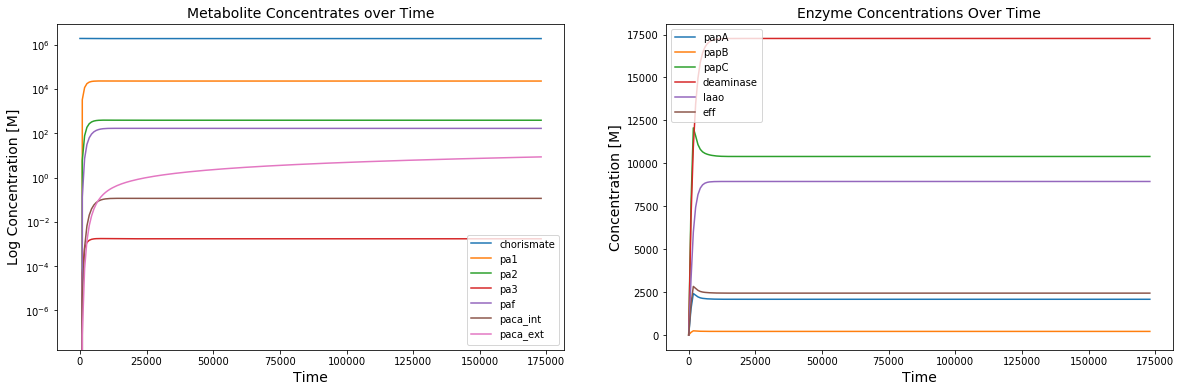

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
endpoint = 'Metabolite Concentrates over Time'
ax = axs[0]
met_list = [chorismate, pa1, pa2, pa3, paf, paca_int, paca_ext]
name_list = ['chorismate','pa1', 'pa2', 'pa3', 'paf', 'paca_int', 'paca_ext']
for i in range(len(met_list)):
    ax.plot(t, met_list[i], label=name_list[i])
ax.set_title(f'{endpoint}', fontsize=14)
ax.legend()
ax.set_yscale('log')
ax.set_ylabel('Log Concentration [M]', fontsize=14)
ax.set_xlabel('Time', fontsize=14)

ax = axs[1]
enzy_list = [papA, papB, papC, deaminase, laao, eff]
name_list = ['papA', 'papB', 'papC', 'deaminase', 'laao', 'eff']
endpoint = 'Enzyme Concentrations Over Time'
for i in range(len(enzy_list)):
    ax.plot(t, enzy_list[i], label=name_list[i])
ax.set_title(f'{endpoint}', fontsize=14)
ax.legend()
ax.set_ylabel('Concentration [M]', fontsize=14)
ax.set_xlabel('Time', fontsize=14)


In [18]:
losses = []
params = []
circuits = []
sols = []
def objective(args):
    architecture, thetas, ks = args
    #Integration conditions
    t = np.linspace(0, 1.73E5, 200) 
    y0 = np.array([0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0. , 0., 0., 0., 0., 0., 0., 0., 0., 0.]) 
    extra_options = {'old_api': False, 'user_data': [architecture, thetas, ks], 'rtol':1E-4}
    ode_solver = ode('cvode', p_aminostyrene, **extra_options)
    solution = ode_solver.solve(t, y0)
    j1, j2 = solution.values.y[-1, -2:]
    j1, j2, loss = loss_biological(j1, j2, alpha1=1E-12, alpha2=1E-7)
    losses.append(loss)
    params.append([thetas, ks])
    circuits.append(architecture)
    return loss
    

In [19]:
best = fmin(objective, arch_agnostic_space, algo=tpe.suggest, max_evals=1000)
space_eval(arch_agnostic_space, best)

100%|██████████| 1000/1000 [01:31<00:00, 10.98trial/s, best loss: 0.20933000000000004]


((((1, 0, 0), (1, 0, 0), (1, 0, 0)), ((1, 0, 0), (1, 0, 0), (1, 0, 0))),
 ((9.396849720740967, 4.332313102190932, 5.3430382082764165),
  (0.35366453769384876, 0.013063375920610465, 6.021701744818393)),
 ((2.0873214162875775,
   1.165129183653291,
   1.4455410517013134,
   1.867770738843757,
   2.115065231449983),
  (4.484226207952219,
   1.417863965793436,
   4.827699070441675,
   4.221238061562003,
   2.2214122196543236)))

In [23]:
theta_paf_prom1s, theta_paf_prom2s, theta_paf_prom3s, theta_paca_prom1s, theta_paca_prom2s, theta_paca_prom3s = [[], [], [], [], [], []]
k_paf_papAs, k_paf_papBs, k_paf_papCs, k_paf_prom2s, k_paf_prom3s, k_paca_papAs, k_paca_papBs, k_paca_papCs, k_paca_prom2s, k_paca_prom3s = [[], [], [], [], [], [], [], [], [], []]
for i in range(len(params)):
    thetas = params[0][0]
    ks = params[0][1]
    theta_paf_prom1, theta_paf_prom2, theta_paf_prom3 = thetas[0]
    theta_paca_prom1, theta_paca_prom2, theta_paca_prom3 = thetas[1]
    k_paf_papA, k_paf_papB, k_paf_papC, k_paf_prom2, k_paf_prom3 = ks[0]
    k_paca_papA, k_paca_papB, k_paca_papC, k_paca_prom2, k_paca_prom3 = ks[1]

    theta_paf_prom1s.append(theta_paf_prom1)
    theta_paf_prom2s.append(theta_paf_prom2)
    theta_paf_prom3s.append(theta_paf_prom3)
    theta_paca_prom1s.append(theta_paca_prom1)
    theta_paca_prom2s.append(theta_paca_prom2)
    theta_paca_prom3s.append(theta_paca_prom3)
    k_paf_papAs.append(k_paf_papA)
    k_paf_papBs.append(k_paf_papB)
    k_paf_papCs.append(k_paf_papC)
    k_paf_prom2s.append(k_paf_prom2)
    k_paf_prom3s.append(k_paf_prom3)
    k_paca_papAs.append(k_paca_papA)
    k_paca_papBs.append(k_paca_papB)
    k_paca_papCs.append(k_paca_papC)
    k_paca_prom2s.append(k_paca_prom2)
    k_paca_prom3s.append(k_paca_prom3)



landscape = pd.DataFrame({'circuit':circuits, 'loss': losses, 'theta_paf_prom1':theta_paf_prom1s, 'theta_paf_prom2':theta_paf_prom2s, 'theta_paf_prom3':theta_paf_prom3s,
            'theta_paca_prom1':theta_paca_prom1s, 'theta_paca_prom2':theta_paca_prom2s, 'theta_paca_prom3':theta_paca_prom3,
            'k_paf_papA':k_paf_papAs, 'k_paf_papB':k_paf_papBs, 'k_paf_papC':k_paf_papCs, 'k_paf_prom2':k_paf_prom2s, 'k_paf_prom3':k_paf_prom3s,
            'k_paca_papA':k_paca_papAs, 'k_paca_papB':k_paca_papBs, 'k_paca_papC':k_paca_papCs, 'k_paca_prom2':k_paca_prom2s, 'k_paca_prom3':k_paca_prom3s})



In [24]:
best_loss = 1E5
best_circuit = 'Initial'
best_losses = []
best_losses_circuits = []
for i in range(len(landscape)):
    if landscape.loss[i] < best_loss:
        best_loss = landscape.loss[i]
        best_circuit = landscape.circuit[i]
    best_losses.append(best_loss)
    best_losses_circuits.append(best_circuit)
landscape['best_losses'] = best_losses
landscape['best_loss_circuit'] = best_losses_circuits

/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/Users/charlotte/opt/anaconda3/envs/sundials/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


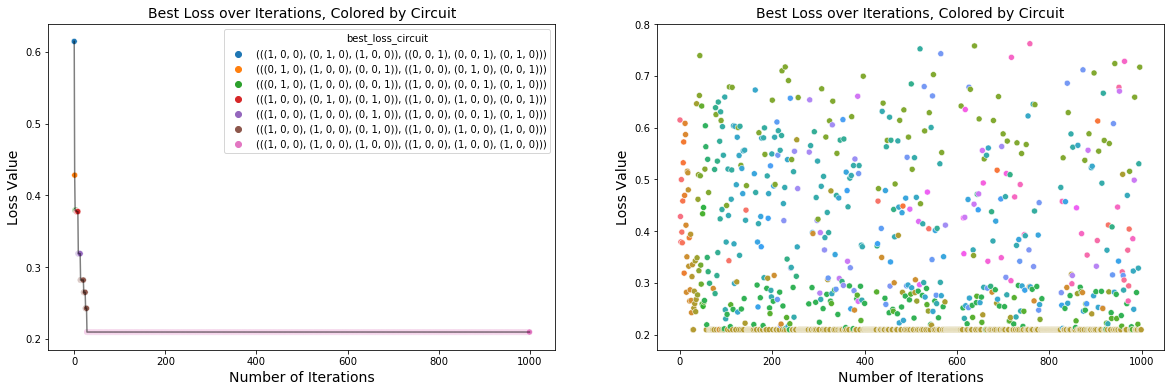

In [25]:
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
endpoint = 'Best Loss over Iterations, Colored by Circuit'

ax = axs[0]
ax.plot(best_losses, 'k-', alpha=0.5)
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(range(len(landscape)), 'best_losses', hue='best_loss_circuit',data=landscape,  ax=ax)


ax = axs[1]
ax.set_title(f'{endpoint}', fontsize=14)
ax.set_ylabel('Loss Value', fontsize=14)
ax.set_xlabel('Number of Iterations', fontsize=14)
sns.scatterplot(range(len(landscape)), 'loss', hue='circuit', data=landscape, ax=ax, legend=False)
fig.savefig('p-as_anyarch_1000_try2.png')

1899827.6970062307


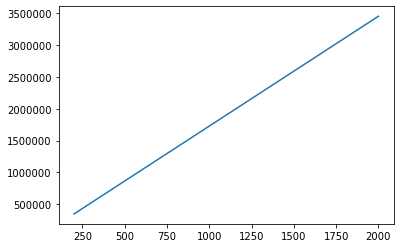

In [4]:
#Trying to find steady state chorismate synthesis
def steady_state_chorismate(t, y, ydot, param):
    chorismate_biosynthesis = param #/(1+2**((-1*(t-10800))/2000))
    dilution_rate = 5.79E-4
    chorismate = y
    ydot[0] = chorismate_biosynthesis - chorismate*dilution_rate

t = np.linspace(0, 1.73E5, 200) 
y0 = np.array([0.])
ss_chorismate = []
for chorismate_biosynthesis in np.linspace(2E2, 2E3, 100):
    extra_options = {'old_api': False, 'rtol':1E-4, 'user_data': [chorismate_biosynthesis]}
    ode_solver = ode('cvode', steady_state_chorismate, **extra_options)
    solution = ode_solver.solve(t, y0)
    ss_chorismate.append(solution.values.y[-1])

print(np.mean(ss_chorismate))
plt.plot(np.linspace(2E2, 2E3, 100), ss_chorismate)

We can have PAF and PACA control simultaneously - what should the option be where only one is present? k_paca, k_paf, or k_ol? 
Right now I am just using the same architecture encoding as before, implying that open loop control is (k_paca + k_paf).

We treat the sigmoids as additive and keep the same mRNA legnth.

Currently, only specified architectures can be tested.

In [34]:
space = hp.choice('architecture', [
    ([[0, 1, 0], [0, 1, 0], [0, 1, 0]], [[0, 1, 0], [0, 1, 0], [0, 1, 0]], 
            [[hp.uniform('a1_theta_paf_prom1', 1E-7, 10), hp.uniform('a1_theta_paf_prom2', 1E-7, 10), hp.uniform('a1_theta_paf_prom3', 1E-7, 10)], [hp.uniform('a1_theta_paca_prom1', 1E-7, 10), hp.uniform('theta_paca_prom2', 1E-7, 10), hp.uniform('theta_paca_prom2', 1E-7, 10)]], 
            [[hp.uniform('a1_k_paf_papA', 1E-7, 5), hp.uniform('a1_k_paf_papB', 1E-7, 5), hp.uniform('a1_k_paf_papC', 1E-7, 5), hp.uniform('a1_k_paf_prom2', 1E-7, 5), hp.uniform('a1_k_paf_prom3', 1E-7, 5)], [hp.uniform('k_paca_papA', 1E-7, 5), hp.uniform('k_paca_papB', 1E-7, 5), hp.uniform('k_paca_papC', 1E-7, 5), hp.uniform('k_paca_prom2', 1E-7, 5), hp.uniform('k_paca_prom3', 1E-7, 5)]]),

    ([[0, 0, 1], [0, 0, 1], [0, 0, 1]], [[0, 0, 1], [0, 0, 1], [0, 0, 1]], 
            [[hp.uniform('theta_paf_prom1', 1E-7, 10), hp.uniform('theta_paf_prom2', 1E-7, 10), hp.uniform('theta_paf_prom3', 1E-7, 10)], [hp.uniform('theta_paca_prom1', 1E-7, 10), hp.uniform('theta_paca_prom2', 1E-7, 10), hp.uniform('theta_paca_prom2', 1E-7, 10)]], 
            [[hp.uniform('k_paf_papA', 1E-7, 5), hp.uniform('k_paf_papB', 1E-7, 5), hp.uniform('k_paf_papC', 1E-7, 5), hp.uniform('k_paf_prom2', 1E-7, 5), hp.uniform('k_paf_prom3', 1E-7, 5)], [hp.uniform('k_paca_papA', 1E-7, 5), hp.uniform('k_paca_papB', 1E-7, 5), hp.uniform('k_paca_papC', 1E-7, 5), hp.uniform('k_paca_prom2', 1E-7, 5), hp.uniform('k_paca_prom3', 1E-7, 5)]])
])
